### 老空转平台与10X Visium的有些不一致。我们这里拿人类胰腺癌数据 section A1为例子进行介绍

In [8]:
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import os

### Old ST平台的数据文件大多以.h5ad为后缀，因此使用sc.read_h5ad进行读取

In [9]:

# 设定文件夹路径
path = 'D:/st_projects/data/PDAC'
# 设定切片ID，比如我要读取DLPFC的151673切片数据
section = 'A1'
# 路径拼接
spatial_path = os.path.join(path, section)
count_file = 'ST_PDAC_A_ST1.h5ad'

adata = sc.read_h5ad(os.path.join(spatial_path, count_file))
display(adata)

AnnData object with n_obs × n_vars = 428 × 19738
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mito', 'log1p_total_counts_mito', 'pct_counts_mito', 'clusters', 'leiden'
    var: 'mito', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg', 'leiden', 'leiden_colors', 'moranI', 'neighbors', 'pca', 'rank_genes_groups', 'spatial_neighbors', 'umap'
    obsm: 'X_pca', 'X_umap', 'spatial'
    varm: 'PCs'
    layers: 'raw_count', 'raw_counts'
    obsp: 'connectivities', 'distances', 'spatial_connectivities', 'spatial_distances'

### 接着，我们读取位置信息与图像信息

In [10]:
image_position = pd.read_csv(os.path.join(spatial_path, 'spatial/position_label.txt'), sep='\t', index_col=None)
image_position.index = image_position['dot_xy'].values
image_position.index.name = 'spots'
adata.obs = adata.obs.join(image_position, how="left")

In [13]:
from pathlib import Path
from PIL import Image

spatial_path = Path(spatial_path)
image_path = spatial_path / 'spatial/GSM3036911_PDAC-A-ST1-HE.png'
# Old ST的count数据中没有library id等数据，所以手动设置
library_id = 'A1'
# Old ST数据只有全尺寸图像，导致电脑在渲染可视化图的时候会很卡。设置quality=hires原因是，sc.pl.spatial无法展示fullres的图像信息
quality = 'hires'
scale = 1.0
# Old ST 每个Spot在100微米左右
spot_diameter_fullres = 100

# 由于图像太大，移除掉Pillow对输入图像像素大小的限制
Image.MAX_IMAGE_PIXELS = None
img = plt.imread(image_path, 0)
adata.uns["spatial"] = dict()
adata.uns["spatial"][library_id] = dict()
adata.uns["spatial"][library_id]['images'] = dict()
adata.uns["spatial"][library_id]['images'][quality] = img
adata.uns["spatial"][library_id]["use_quality"] = quality
adata.uns["spatial"][library_id]['scalefactors'] = dict()
adata.uns["spatial"][library_id]['scalefactors']["tissue_" + quality + "_scalef"] = scale
adata.uns["spatial"][library_id]['scalefactors']['spot_diameter_fullres'] = spot_diameter_fullres

adata.obsm["spatial"] = adata.obs[['pixel_x', 'pixel_y']].values
adata.obs[["imagecol", "imagerow"]] = adata.obsm["spatial"] * scale

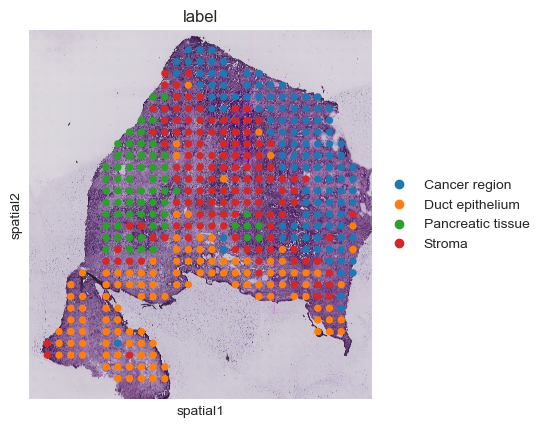

In [16]:
# 在Old ST上，想要可视化数据，需要手动指定library_id, scale_factor等参数, size参数用于控制单个spot在图像上的半径
sc.pl.spatial(adata, color='label', library_id='A1', size=5, scale_factor=1.0)

### 接下来就是常规流程，包括数据预处理、降维、聚类等下游任务。由于拿到的数据就是预处理过的，我们不再赘述

In [17]:
adata

AnnData object with n_obs × n_vars = 428 × 19738
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mito', 'log1p_total_counts_mito', 'pct_counts_mito', 'clusters', 'leiden', 'dot_xy', 'pixel_x', 'pixel_y', 'label', 'imagecol', 'imagerow'
    var: 'mito', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg', 'leiden', 'leiden_colors', 'moranI', 'neighbors', 'pca', 'rank_genes_groups', 'spatial_neighbors', 'umap', 'spatial', 'label_colors'
    obsm: 'X_pca', 'X_umap', 'spatial'
    varm: 'PCs'
    layers: 'raw_count', 'raw_counts'
    obsp: 'connectivities', 'distances', 'spatial_connectivities', 'spatial_distances'